# 社群媒體分析 — 期末專案

* 組員: M124020028 何允中、M124111057 張伶宣

## 大綱

1. 分析目的與內容
2. 環境設定 & 資料前處理
3. Word cloud
4. 情緒分析

## 分析目的與內容

為了觀察不同時期，熱門手機遊戲的變化，以及不同手機遊戲之間的類型關聯性，藉此探索玩家喜好和遊戲產業發展。

* 資料來源: PTT 論壇，手機遊戲類各看板
* 資料量: 28975

## Python 與 IPython 環境設定

### 套件安裝

In [1]:
%pip install requests beautifulsoup4 \
    numpy pandas torch \
    jieba wordcloud matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

### 確保可重現性

In [2]:
# `PYTHONHASHSEED` environment variable should not be set from within IPython notebook,
# as it's only effective if set *before* Python interpreter is running

# Ensure results reproducibility of CUDA cuBLAS API
%env CUBLAS_WORKSPACE_CONFIG :4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [3]:
# Seed utilities, adapted from previous project

import torch
import random
import numpy as np
from numpy import random as np_random
from numpy.random import Generator, BitGenerator, RandomState, SeedSequence
from collections.abc import Sequence, Callable
from typing import Any, TypeAlias, TypeVar
import inspect
import functools

T = TypeVar("T")

def copy_special(target: T, source: Any, *names: str) -> T:
    for name in names:
        attribute = f"__{name}__"
        setattr(target, attribute, getattr(source, attribute))
    return target

NumpySeed: TypeAlias = None | int | Sequence[int] | SeedSequence | BitGenerator | Generator | RandomState

def patch_numpy_random_default_rng(seed: NumpySeed=0) -> Callable[[NumpySeed], Generator]:
    FUNCTION_NAME = "default_rng"
    ATTRIBUTE_NAME = f"{np_random.__name__}.{FUNCTION_NAME}"
    COPY_ATTRIBUTE_NAMES = ("name", "doc", "qualname")

    get_current = lambda: getattr(np_random, FUNCTION_NAME)
    get_original = lambda: getattr(np_random, ATTRIBUTE_NAME, get_current())
    (current_module_name, numpy_module_name) = map(lambda module: module.__name__, (inspect.getmodule(get_current), np))
    is_original = current_module_name == numpy_module_name or current_module_name.startswith(f"{numpy_module_name}.")

    if seed is None:
        if is_original:
            return get_current
        original = get_original()
        setattr(np_random, FUNCTION_NAME, original)
        return original
    else:
        original = get_current
        if is_original:
            setattr(np_random, ATTRIBUTE_NAME, original)
        else:
            original = get_original()

        def default_rng(original: Callable[[NumpySeed], Generator], seed: NumpySeed=seed) -> Generator:
            return original(seed)
        copy_special(default_rng, original, *COPY_ATTRIBUTE_NAMES)
        partial = functools.partial(default_rng, original)
        copy_special(partial, default_rng, *COPY_ATTRIBUTE_NAMES, "module")

        setattr(np_random, FUNCTION_NAME, partial)
        return original

def enable_deterministic_torch() -> None:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)

def set_seed(seed: int, deterministic: bool=True, patch_numpy: bool=True) -> None:
    if deterministic:
        enable_deterministic_torch()
    torch.manual_seed(seed)
    seed_non_torch(seed, patch_numpy)

def seed_non_torch(seed: int, patch_numpy: bool=True) -> None:
    random.seed(seed)
    np_random.seed(seed)
    patch_numpy_random_default_rng(seed if patch_numpy else None)

In [4]:
GLOBAL_SEED=2025
set_seed(GLOBAL_SEED)

### 繪圖設定

In [5]:
from matplotlib import pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties

font_path = 'TaipeiSansTCBeta-Regular.ttf'
fontManager.addfont(font_path)
fprop = FontProperties(fname=font_path)
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

### 連接 Google Drive 資料夾

In [6]:
import os
from pathlib import PurePath
import re
from contextlib import suppress

with suppress(ImportError):
    from google.colab import drive

    if input("Do you want to mount Google Drive? [y/n] ").casefold() \
            in [answer.casefold() for answer in ("y", "yes")]:
        mount_path = "/content/drive"
        drive.mount(mount_path)

        os.chdir(PurePath(mount_path) / re.sub(r"^/+", "", input("Enter path to project root: ")))

Do you want to mount Google Drive? [y/n] n


## 資料獲取與資料前處理

### PTT 資料爬蟲

In [7]:
import os
from os import PathLike
from pathlib import Path, PurePosixPath
import random
from urllib import parse
from urllib.parse import ParseResult, SplitResult, ParseResultBytes, SplitResultBytes
import re
from enum import Enum
import time
from time import struct_time
from datetime import datetime, date, timedelta, timezone, tzinfo
import math
import base64
from configparser import ConfigParser
import html.parser
import email.utils
from dataclasses import dataclass
from contextlib import suppress, AbstractContextManager
from typing import Any, TypeVar, TypeAlias, overload
from collections.abc import Iterable, Mapping, Callable, Sequence
try:
    from typing import Self
except ImportError:
    from typing import Any as Self
try:
    from collections.abc import Buffer
except ImportError:
    from typing import Any as Buffer
try:
    from typing import override
except ImportError:
    C = TypeVar("C", bound=Callable[..., Any])
    def override(function: C) -> C:
        with suppress(AttributeError, TypeError):
            function.__override__ = True
        return function

import requests
from requests import Request, Session
from requests.exceptions import Timeout, RequestException
from bs4 import BeautifulSoup, NavigableString, Tag
from bs4 import StopParsing, ParserRejectedMarkup, FeatureNotFound

UTF8_ENCODING = "utf-8"
APPLICATION_NAME = "ptt-scraper"

# ========== Miscellaneous ==========

def calculate_chrome_version(d: date | None=None) -> int:
    start_date = date(2021, 9, 21)
    if d is None:
        d = date.today()
    elif d < start_date:
        raise ValueError(f"Date before {start_date} is not supported")
    skips = (d.year - start_date.year) * 31
    if d.month == 12:
        skips += d.day
    return 94 + math.floor(((d - start_date).days - skips) / 7 / 4)

# ========== Miscellaneous ==========

# ========== Common ==========

def assert_raise(
    new_exception: Callable[[], Exception] | None=lambda: Exception("Assertion failed")
) -> Callable[..., None]:
    def check(*values: Any) -> None:
        if not all([value() if callable(value) else value for value in values]):
            raise new_exception()
    return check

# ========== Common ==========

# ========== URL ==========

def base64_url(url: str | Buffer) -> str:
    return base64.urlsafe_b64encode(
        url.encode() if isinstance(url, str) else url).decode()

@overload
def normalize_url(url: str | ParseResult | SplitResult, *args, **kwargs) -> str:
    ...

@overload
def normalize_url(url: bytes | bytearray | ParseResultBytes | SplitResultBytes,
        *args, **kwargs) -> bytes:
    ...

def normalize_url(
    url: str | bytes | bytearray | \
        ParseResult | SplitResult | ParseResultBytes | SplitResultBytes,
    *args, **kwargs
) -> str | bytes:
    if isinstance(url, (str, bytes, bytearray)):
        url = parse.urlsplit(url, *args, **kwargs)
    ENCODING = "ascii"
    is_bytes = isinstance(url, (ParseResultBytes, SplitResultBytes))
    _ = lambda string: string.encode(ENCODING) if is_bytes else string
    netloc = url.netloc
    auth, auth_separator, remaining = netloc.partition(_("@"))
    if len(auth_separator) == 0:
        remaining = auth
        auth = _("")
    hostname, port_separator, port = remaining.rpartition(_(":"))
    if len(port_separator) == 0:
        hostname = port
        port = _("")
    if is_bytes:
        hostname = hostname.decode(ENCODING)
    hostname = hostname.encode("idna").decode().lower()
    if is_bytes:
        hostname = hostname.encode(ENCODING)
    url = url._replace(netloc=auth + auth_separator + hostname + port_separator + port)
    return url.geturl()

@overload
def url_join_segments(url: str | ParseResult | SplitResult,
        *segments: str, **kwargs) -> str:
    ...

@overload
def url_join_segments(url: bytes | bytearray | ParseResultBytes | SplitResultBytes,
        *segments: bytes | bytearray, **kwargs) -> bytes:
    ...

def url_join_segments(url: str | bytes | bytearray | \
        ParseResult | SplitResult | ParseResultBytes | SplitResultBytes,
    *segments: str | bytes | bytearray, **kwargs) -> str | bytes:
    if isinstance(url, (str, bytes, bytearray)):
        url = parse.urlsplit(url, **kwargs)
    is_bytes = isinstance(url, (ParseResultBytes, SplitResultBytes))
    _ = lambda string: string.encode("ascii") if is_bytes else string
    url = url._replace(
        path=str(PurePosixPath(
            url.path,
            *[re.sub(_(r"^/+"), _(""), segment) for segment in segments]
        ))
    )
    return url.geturl()

# ========== URL ==========

# ========== Datetime ==========

def to_datetime(value: str | datetime | int | float | struct_time,
        default_timezone: tzinfo | None=None) -> datetime:
    if isinstance(value, str):
        try:
            value = datetime.fromisoformat(value)
            if value.tzinfo is None and default_timezone is not None:
                value = value.replace(tzinfo=default_timezone)
        except ValueError:
            return to_datetime(time.strptime(value), default_timezone)
    elif isinstance(value, struct_time):
        timezone_info = default_timezone
        zone_offset = value.tm_gmtoff
        if zone_offset is not None:
            timezone_info = timezone(timedelta(seconds=zone_offset))
        value = datetime(
            value.tm_year,
            value.tm_mon,
            value.tm_mday,
            value.tm_hour,
            value.tm_min,
            value.tm_sec,
            tzinfo=timezone_info
        )
    elif isinstance(value, (int, float)):
        value = datetime.fromtimestamp(value, tz=default_timezone)
    elif not isinstance(value, datetime):
        raise TypeError(f"Cannot convert {type(value).__name__} to datetime")
    return value

# ========== Datetime ==========

# ========== HTML parsing ==========

def tag_has_class(tag: Any, class_name: str) -> bool:
    return isinstance(tag, Tag) and class_name in tag.get("class", [])

def is_whitespace(page_element: Any, auto_decompose: bool=False) -> bool:
    result = isinstance(page_element, NavigableString) and \
        len(page_element.get_text(strip=True)) == 0
    if result and auto_decompose:
        page_element.decompose()
    return result

@overload
def get_base_url(url: str | ParseResult | SplitResult,
        soup: BeautifulSoup | None=None) -> str | None:
    ...

@overload
def get_base_url(url: bytes | bytearray | ParseResultBytes | SplitResultBytes,
        soup: BeautifulSoup | None=None) -> bytes | None:
    ...

"""
url                             | <base> href                     | return value
------------------------------- | ------------------------------- | --------------------------------
/path                           | (anything)                      | None
path                            | (anything)                      | None
https://example.org/path1/path2 | None                            | https://example.org/path1/
https://example.org/path1/path2 | https://example.com/path3/path4 | https://example.com/path3/
https://example.org/path1/path2 | /path3/path4                    | https://example.org/path3/
https://example.org/path1/path2 | path3/path4                     | https://example.org/path1/path3/

"""
def get_base_url(
    url: str | bytes | bytearray | \
        ParseResult | SplitResult | ParseResultBytes | SplitResultBytes,
    soup: BeautifulSoup | None=None
) -> str | bytes | None:
    is_bytes = isinstance(url, (bytes, bytearray, ParseResultBytes, SplitResultBytes))
    _ = lambda string: string.encode("ascii") if is_bytes else string
    if isinstance(url, (str, bytes, bytearray)):
        url = parse.urlsplit(url, scheme=_("https"))
    if len(url.netloc) == 0:
        return None
    original_base_url = parse.urljoin(url.geturl(), _("."))
    if soup is None:
        return original_base_url
    ATTRIBUTE = "href"
    base_tag = soup.select_one(f"base[{ATTRIBUTE}]")
    if base_tag is None:
        return original_base_url
    base_url = base_tag[ATTRIBUTE]
    if re.match(r"^(?:https?:)?//[A-Za-z0-9-]+", base_url) is not None:
        return _(parse.urljoin(base_url, "."))
    return parse.urljoin(parse.urljoin(original_base_url, _(base_url)), _("."))

@overload
def get_anchor_url(anchor_tag: Tag,
        base_url: str | ParseResult | SplitResult="") -> str | None:
    ...

@overload
def get_anchor_url(
    anchor_tag: Tag,
    base_url: bytes | bytearray | ParseResultBytes | SplitResultBytes
) -> bytes | None:
    ...

def get_anchor_url(
    anchor_tag: Tag,
    base_url: str | bytes | bytearray | \
        ParseResult | SplitResult | ParseResultBytes | SplitResultBytes=""
) -> str | bytes | None:
    if isinstance(base_url,
            (ParseResult, SplitResult, ParseResultBytes, SplitResultBytes)):
        base_url = base_url.geturl()
    href = anchor_tag.get("href")
    if isinstance(base_url, (bytes, bytearray)):
        href = href.encode("ascii")
    return None if href is None else parse.urljoin(base_url, href)

# ========== HTML parsing ==========

@dataclass
class TextResourceAtLocation():
    url: str
    text: str

class Downloader(AbstractContextManager):

    def __init__(self,
            cache_directory: str | bytes | bytearray | PathLike | None=None) -> None:
        self._session = Session()
        self._session.headers["User-Agent"] = \
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) " \
            "AppleWebKit/537.36 (KHTML, like Gecko) " \
            f"Chrome/{calculate_chrome_version()}.0.0.0 Safari/537.36"
        requests.utils.add_dict_to_cookiejar(self._session.cookies, { "over18": "1" })
        self.cache_directory = cache_directory

    @property
    def cache_directory(self) -> Path | None:
        return self._cache_directory

    @cache_directory.setter
    def cache_directory(self, value: str | bytes | bytearray | PathLike):
        if isinstance(value, (bytes, bytearray)):
            value = value.decode()
        elif not isinstance(value, str):
            self.cache_directory = os.fspath(value)
            return
        self._cache_directory = Path(value)

    @cache_directory.deleter
    def cache_directory(self):
        self._cache_directory = None

    @override
    def __enter__(self) -> Self:
        self._session.__enter__()
        return self

    @override
    def __exit__(self, *_, **__) -> bool:
        self._session.__exit__(*_, **__)
        return False

    def close(self) -> None:
        self._session.close()

    @overload
    def url_cache(self, url: str) -> str | None:
        ...

    @overload
    def url_cache(self, url: str, destination: str) -> str:
        ...

    def url_cache(self, url: str, destination: str | None=None) -> str | None:
        if self.cache_directory is None:
            raise Exception("Cache directory is not set")
        url = normalize_url(url)
        if destination is not None and url == normalize_url(destination):
            return destination

        SECTION = "InternetShortcut"
        KEY = "URL"
        file_path = self.cache_directory / f"{base64_url(url)}.url"
        parser = ConfigParser(default_section=SECTION, interpolation=None)
        if destination is None:
            with suppress(OSError):
                with open(file_path, encoding=UTF8_ENCODING) as file:
                    parser.read_file(file)
                return parser.get(SECTION, KEY, fallback=None)
        else:
            self.cache_directory.mkdir(parents=True, exist_ok=True)
            with open(file_path, mode="w", encoding=UTF8_ENCODING) as file:
                parser.add_section(SECTION)
                parser.set(SECTION, KEY, destination)
                parser.write(file)
            return destination

    @overload
    def file_cache(self, url: str) -> str | None:
        ...

    @overload
    def file_cache(self, url: str, string: str, *, auto_newline: bool=True) -> str:
        ...

    def file_cache(self, url: str, string: str | None=None,
            *, auto_newline: bool=True) -> str | None:
        if self.cache_directory is None:
            raise Exception("Cache directory is not set")
        file_path = self.cache_directory / base64_url(normalize_url(url))
        if string is None:
            with suppress(OSError):
                with open(file_path, encoding=UTF8_ENCODING) as file:
                    return file.read()
        else:
            if auto_newline and not string.endswith("\n"):
                string += "\n"
            self.cache_directory.mkdir(parents=True, exist_ok=True)
            with open(file_path, mode="w", encoding=UTF8_ENCODING) as file:
                file.write(string)
            return string

    def get(
        self, url: Any, force_new: bool=False, *,
        send_kwargs: Mapping[str, Any]={}, **request_kwargs
    ) -> tuple[TextResourceAtLocation, bool]:
        prepare_request = lambda url: \
            self._session.prepare_request(Request("GET", url, **request_kwargs))

        if not force_new and self.cache_directory is not None:
            prepared_url = prepare_request(url).url
            while True:
                destination_url = self.url_cache(prepared_url)
                if destination_url is None:
                    break
                prepared_url = destination_url
            cached = self.file_cache(prepared_url)
            if cached is not None:
                return TextResourceAtLocation(prepared_url, cached), False

        prepared_url = None
        response = None
        start_time = datetime.now(timezone.utc)
        while True:
            prepared_request = prepare_request(url)
            prepared_url = prepared_request.url
            response = self._session.send(prepared_request, **send_kwargs)
            if response.status_code != requests.codes.too_many_requests:
                break

            now = datetime.now(timezone.utc)
            retry_after = response.headers.get("Retry-After")
            is_absolute_time = False
            if retry_after is None:
                retry_after = 5
            elif re.fullmatch(r"^[0-9]+$", retry_after) is not None:
                retry_after = max(0, int(retry_after))
            else:
                retry_after = email.utils.parsedate_to_datetime(retry_after)
                if retry_after < now:
                    retry_after = 0
                else:
                    is_absolute_time = True

            delta = \
                (retry_after - start_time).total_seconds() \
                if is_absolute_time else \
                (now - start_time).total_seconds() + retry_after
            if delta > 90:
                raise Timeout(response=response)
            else:
                time.sleep((retry_after - now).total_seconds() if is_absolute_time
                    else retry_after)

        response.raise_for_status()
        text = response.text

        destination_url = response.url
        if self.cache_directory is not None:
            with suppress(OSError):
                text = self.file_cache(destination_url, text)
                self.url_cache(prepared_url, destination_url)

        return TextResourceAtLocation(destination_url, text), True

class PttDocument():
    def __init__(self, url: str, document: str | None=None) -> None:
        self._url = url
        self._document = document

    @property
    def url(self) -> str:
        return self._url

    @property
    def document(self) -> str | None:
        return self._document

PttArticleAlias: TypeAlias = "PttArticle"
class PttArticle(PttDocument):

    class Partial():
        def __init__(self, url: str, /, *, author: str, board: str, title: str) -> None:
            self.url = url
            self.author = author
            self.board = board
            self.title = title

    @classmethod
    def from_document(Cls, document: str, url: str) -> PttArticleAlias:
        check = assert_raise(lambda: ValueError("Not a PTT article document"))

        soup = BeautifulSoup(document, html.parser.__name__)
        content_div = soup.select_one("#main-container #main-content")
        check(content_div is not None)
        contents = content_div.contents

        metadata = {
            "作者": "author",
            "看板": "board",
            "標題": "title",
            "時間": "time"
        }
        meta_div_count = len(metadata)
        found_meta_div_count = 0
        while len(contents) > 0 and found_meta_div_count < meta_div_count:
            meta_div = contents[0]
            if is_whitespace(meta_div, True):
                continue
            check(any([
                tag_has_class(meta_div, f"article-metaline{suffix}")
                for suffix in ("", "-right")
            ]))
            meta_div_contents = meta_div.contents
            i = 0
            while i < len(meta_div_contents):
                if is_whitespace(meta_div_contents[i], True):
                    continue
                i += 1
            check(len(meta_div_contents) == 2)
            meta_key_span, meta_value_span = meta_div_contents
            check(*[
                tag_has_class(span, f"article-meta-{suffix}")
                for suffix, span in ({
                    "tag": meta_key_span,
                    "value": meta_value_span
                }).items()
            ])
            key = meta_key_span.get_text(strip=True)
            check(key in metadata)
            parameter = metadata[key]
            metadata[parameter] = meta_value_span.get_text(strip=True)
            del metadata[key]
            meta_div.decompose()
            found_meta_div_count += 1
        check(found_meta_div_count == meta_div_count)

        CLASS_RICH_CONTENT = "richcontent"
        is_rich_content = lambda node: tag_has_class(node, CLASS_RICH_CONTENT)
        while len(contents) > 0:
            push_div = contents[-1]
            if is_whitespace(push_div) or \
                    tag_has_class(push_div, "push") or is_rich_content(push_div):
                push_div.decompose()
            else:
                break

        #SEPARATOR = "-" * 2
        #meta_span_count = 0
        #potential_start_found = False
        #for i in range(len(contents)):
        #    if contents[-i - 1].get_text(strip=True).startswith("\u203b 發信站:"):
        #        meta_span_count = i + 1
        #        break
        #check(meta_span_count != 0)
        #for _ in range(meta_span_count):
        #    contents[-1].decompose()

        #content_count = len(contents)
        #check(content_count > 0)
        #text_content_end_lines = f"\n{SEPARATOR}\n".splitlines()
        #text_content_end_lines.reverse()

        #visited_nodes = []
        #partial_removals = []
        #found_signature = False
        #i = 0

        #while i < content_count:
        #    i += 1
        #    node = contents[-i]
        #    visited_nodes.insert(0, node)
        #    if is_rich_content(node):
        #        continue
        #    text = "".join([
        #        "\n" if is_rich_content(node) else node.text
        #        for node in visited_nodes
        #    ])
        #    lines = text.splitlines()
        #    lines.reverse()
        #    end_line_count = len(text_content_end_lines)
        #    if i == 1:
        #        check(len(lines) >= end_line_count)
        #        check(*[
        #            lines[j] == text_content_end_lines[j]
        #            for j in range(end_line_count)
        #        ])
        #    lines = lines[end_line_count:]
        #    for j in range(min(len(lines), 7)):
        #        if lines[j] == SEPARATOR:
        #            found_signature = True
        #            break

        #if found_signature:
        #    tail = visited_nodes[0].text.rsplit(SEPARATOR, maxsplit=1)[-1]
        #    tail_split = tail.splitlines()
        #    tail_split.reverse()
        #    partial_removals += tail_split
        #    partial_removals.append(SEPARATOR)
        #    for j in range(1, len(visited_nodes)):
        #        visited_nodes[-j].decompose()
        #else:
        #    partial_removals += text_content_end_lines
        #    visited_nodes.clear()

        text_content = ""
        for content in contents:
            if is_rich_content(content):
                text_content += " "
                children = content.contents
                i = 0
                while i < len(children):
                    if is_whitespace(children[i], True):
                        continue
                    i += 1
                is_image = False
                if len(children) == 1:
                    child = children[0]
                    if isinstance(child, Tag) and child.name == "img":
                        is_image = True
                        alt_text = child.get("alt", "")
                        text_content += "圖片" if len(alt_text) == 0 else alt_text
                if not is_image:
                    iframe = content.select_one("iframe.youtube-player")
                    if iframe is not None:
                        text_content += "影片"
                text_content += "\n"
            elif isinstance(content, Tag) and content.name == "a":
                text_content += re.sub(r"[^\s]+", "網址", content.text)
            else:
                text_content += content.text

        #for removal in partial_removals:
        #    text_content = text_content.rsplit(removal, maxsplit=1)[0]

        return Cls(url, **metadata, text_content=text_content, document=document)

    @overload
    def __init__(
        self,
        url: str,
        /, *,
        author: str,
        board: str,
        title: str,
        time: str | datetime | int,
        text_content: str,
        document: str | None=None
    ) -> None:
        ...

    @overload
    def __init__(
        self,
        url: Partial,
        /, *,
        time: str | datetime | int,
        text_content: str,
        document: str | None=None
    ) -> None:
        ...

    def __init__(
        self,
        url: str | Partial,
        /, *,
        author: str | None=None,
        board: str | None=None,
        title: str | None=None,
        time: str | datetime | int,
        text_content: str,
        document: str | None=None
    ) -> None:
        if isinstance(url, PttArticle.Partial):
            author = url.author
            board = url.board
            title = url.title
            url = url.url
        super().__init__(url, document)
        self.author = author
        self.board = board
        self.title = title
        self.time = time
        self.text_content = text_content

    @property
    def time(self) -> int:
        return self._time

    @time.setter
    def time(self, value: str | datetime | int):
        self._time = int(to_datetime(value, timezone(timedelta(hours=8))).timestamp())

    @time.deleter
    def time(self):
        del self._time

    @override
    def __eq__(self, other: Any) -> bool:
        return isinstance(other, type(self)) and self.url == other.url

    @override
    def __hash__(self) -> int:
        return hash(self.url)

PttArticleListingAlias: TypeAlias = "PttArticleListing"
class PttArticleListing(PttDocument, Sequence):

    @classmethod
    def from_document(Cls, document: str, url: str) -> PttArticleListingAlias:
        check = assert_raise(lambda: ValueError("Not a PTT article listing document"))
        soup = BeautifulSoup(document, html.parser.__name__)
        base_url = get_base_url(url, soup)

        board_anchor = soup.select_one("#topbar-container #topbar .board")
        check(board_anchor is not None)
        board = ""
        for content in board_anchor.contents:
            if isinstance(content, NavigableString):
                for string in content.strings:
                    board += string.strip()
        check(len(board) != 0)

        main_container_div = soup.select_one("#main-container")
        check(main_container_div is not None)
        paging_div = main_container_div.select_one(
            "#action-bar-container .btn-group-paging")
        check(paging_div is not None)
        paging_buttons = paging_div.contents
        check(*[
            (tag_has_class(button, "btn") and button.name == "a") or \
            is_whitespace(button)
            for button in paging_buttons
        ])
        previous_url = None
        next_url = None
        for button in paging_buttons:
            if is_whitespace(button) or button.has_attr("disabled"):
                continue
            button_text = button.text
            button_url = get_anchor_url(button, base_url)
            if "\u2039" in button_text:
                previous_url = button_url
            elif "\u203a" in button_text:
                next_url = button_url

        list_div = main_container_div.select_one(".r-list-container")
        check(list_div is not None)
        articles = []
        for content in list_div.contents:
            if tag_has_class(content, "r-list-sep"):
                break
            if is_whitespace(content) or not tag_has_class(content, "r-ent"):
                continue
            title_anchor = content.select_one(".title a")
            if title_anchor is None:
                continue
            article_url = get_anchor_url(title_anchor, base_url)
            if article_url is None:
                continue
            article_title = title_anchor.get_text(strip=True)
            author_div = content.select_one(".meta .author")
            article_author = ""
            if author_div is not None:
                article_author = author_div.get_text(strip=True)
            if len(article_author) == 0:
                article_author = "-"
            articles.append(PttArticle.Partial(article_url,
                author=article_author, board=board, title=article_title))

        return Cls(url, previous=previous_url, next=next_url,
            board=board, articles=articles, document=document)

    def __init__(
        self,
        url: str,
        /, *,
        previous: str | None=None,
        next: str | None=None,
        board: str,
        articles: Iterable[PttArticle.Partial],
        document: str | None=None
    ) -> None:
        super().__init__(url, document)
        self.previous = previous
        self.next = next
        self.board = board
        self.articles = list(articles)

    def page(self, page: int) -> str:
        if page < 0:
            raise ValueError("Invalid page")
        suffix = "" if page == 0 else str(page)
        return parse.urljoin(get_base_url(self.url), f"index{suffix}.html")

    @overload
    def __getitem__(self, index: int) -> PttArticle.Partial:
        ...

    @overload
    def __getitem__(self, index: slice) -> list[PttArticle.Partial]:
        ...

    @override
    def __getitem__(self, index: int | slice) \
            -> PttArticle.Partial | list[PttArticle.Partial]:
        return self.articles[index]

    @override
    def __len__(self) -> int:
        return len(self.articles)

PttBoardListingAlias: TypeAlias = "PttBoardListing"
class PttBoardListing(PttDocument, Sequence):

    @dataclass
    class Entry():
        url: str
        board: str
        category: str
        title: str

    @classmethod
    def from_document(Cls, document: str, url: str) -> PttBoardListingAlias:
        check = assert_raise(lambda: ValueError("Not a PTT board listing document"))
        soup = BeautifulSoup(document, html.parser.__name__)
        base_url = get_base_url(url, soup)

        main_container_div = soup.select_one("#main-container")
        check(main_container_div is not None)
        list_div = main_container_div.select_one(".b-list-container")
        check(list_div is not None)
        entries = []
        for content in list_div.contents:
            if is_whitespace(content):
                continue
            check(tag_has_class(content, "b-ent"))
            children = content.contents
            i = 0
            while i < len(children):
                if is_whitespace(children[i], True):
                    continue
                i += 1
            check(len(children) == 1)
            anchor = children[0]
            if not (tag_has_class(anchor, "board") and anchor.name == "a"):
                continue
            board_url = get_anchor_url(anchor, base_url)
            if board_url is None:
                continue
            name_div, category_div, title_div = [
                anchor.select_one(f".board-{metadata_key}")
                for metadata_key in ("name", "class", "title")
            ]
            check(name_div is not None)
            board_name = name_div.get_text(strip=True)
            check(len(board_name) != 0)
            board_category = ""
            if category_div is not None:
                board_category = category_div.get_text(strip=True)
            board_title = ""
            if title_div is not None:
                board_title = title_div.get_text(strip=True)
            entries.append(PttBoardListing.Entry(
                board_url, board_name, board_category, board_title))

        return Cls(url, entries=entries, document=document)

    def __init__(
        self, url: str, /, *, entries: Iterable[Entry], document: str | None=None
    ) -> None:
        super().__init__(url, document)
        self.entries = list(entries)

    @overload
    def __getitem__(self, index: int) -> Entry:
        ...

    @overload
    def __getitem__(self, index: slice) -> list[Entry]:
        ...

    @override
    def __getitem__(self, index: int | slice) -> Entry | list[Entry]:
        return self.entries[index]

    @override
    def __len__(self) -> int:
        return len(self.entries)

    @override
    def __eq__(self, other: Any) -> bool:
        return isinstance(other, type(self)) and self.url == other.url

    @override
    def __hash__(self) -> int:
        return hash(self.url)

class Crawler():

    class Filter():

        class Attribute(Enum):
            BOARD_NAME = "board name"
            BOARD_CATEGORY = "board category"
            BOARD_TITLE = "board title"
            ARTICLE_TITLE = "title"
            ARTICLE_AUTHOR = "author"

        def __init__(self, attribute: Attribute, pattern: str, *,
                include: bool=True, is_regex: bool=False) -> None:
            self.attribute = attribute
            self.pattern = pattern
            self.include = include
            self.is_regex = is_regex

        def test(
            self,
            target: PttDocument | PttArticle.Partial | PttBoardListing.Entry
        ) -> bool | None:
            matches = False
            return_value = lambda: self.include if matches else None

            if isinstance(target, PttBoardListing):
                return return_value()

            if self.attribute is Crawler.Filter.Attribute.BOARD_NAME:
                board_name = target.board
                if self.is_regex:
                    matches = re.search(self.pattern, board_name) is not None
                elif self.pattern == board_name:
                    matches = True
                return return_value()

            if isinstance(target, PttArticleListing):
                return return_value()

            test_value = None
            string_use_full_match = False

            if isinstance(target, (PttArticle.Partial, PttArticle)):
                if self.attribute is Crawler.Filter.Attribute.ARTICLE_AUTHOR:
                    test_value = target.author
                    string_use_full_match = True
                elif self.attribute is Crawler.Filter.Attribute.ARTICLE_TITLE:
                    test_value = target.title

            elif isinstance(target, PttBoardListing.Entry):
                if self.attribute is Crawler.Filter.Attribute.BOARD_CATEGORY:
                    test_value = target.category
                    string_use_full_match = True
                elif self.attribute is Crawler.Filter.Attribute.BOARD_TITLE:
                    test_value = target.title

            if test_value is None:
                return return_value()
            if self.is_regex:
                matches = re.search(self.pattern, test_value) is not None
            elif string_use_full_match:
                matches = self.pattern == test_value
            else:
                matches = self.pattern in test_value
            return return_value()

    def __init__(self,
            cache_directory: str | bytes | bytearray | PathLike | None=None) -> None:
        self._downloader = Downloader(cache_directory)
        self._handlers = {}
        self.register_handler(
            r"^(?:https?:)?//[^/]+/bbs/[^/]+/(?:M|G)\.[0-9]{9,10}\.A(?:\.[0-9A-F]{3})?\.html$",
            PttArticle.from_document
        ).register_handler(
            r"^(?:https?:)?//[^/]+/bbs/[^/]+(/(index[0-9]*\.html)?)?$",
            PttArticleListing.from_document
        ).register_handler(
            r"^(?:https?:)?//[^/]+/cls/[0-9]+$", PttBoardListing.from_document
        )

    def register_handler(self, pattern: str,
            handler: Callable[[str, str], PttDocument]) -> Self:
        if pattern in self._handlers:
            raise Exception(f"Pattern \"{pattern}\" is already registered")
        self._handlers[pattern] = handler
        return self

    def unregister_handler(self, pattern: str) -> bool:
        has_pattern = pattern in self._handlers
        if has_pattern:
            del self._handlers[pattern]
        return has_pattern

    def to_document(self, document: str, url: str) -> PttDocument:
        pattern = None
        match = None
        transformed_url = None

        for current_url in (url, normalize_url(url)):
            for current_pattern in self._handlers:
                current_match = re.search(current_pattern, current_url)
                if current_match is None:
                    continue
                current_match_span = current_match[0]
                if match is None or len(current_match_span) > len(match):
                    pattern = current_pattern
                    match = current_match_span
            if pattern is not None:
                transformed_url = current_url
                break

        if pattern is None:
            raise Exception(f"No handler is registered for document at URL \"{url}\"")
        return self._handlers[pattern](document, transformed_url)

    def activity_frequency(self,
            board: str | PttArticleListing | PttBoardListing.Entry) -> float:
        def re_raise(exception: Exception, _: Any) -> None:
            raise exception
        T = TypeVar("T", bound=PttDocument)
        def crawl_single(url: str, Type: type[T]) -> T:
            documents = self.crawl(url, single=True, on_error=re_raise)
            error_message = f"Failed to crawl \"{url}\""
            if len(documents) == 0:
                raise Exception(error_message)
            document = documents[0]
            if not isinstance(document, Type):
                raise Exception(error_message)
            return document

        paginated_listings = {}
        if isinstance(board, PttArticleListing):
            is_earliest_or_latest = False
            for page in (0, 1):
                listing_url = board.page(page)
                value = None
                if board.url == listing_url:
                    value = board
                    is_earliest_or_latest = True
                paginated_listings[listing_url] = value
            if not is_earliest_or_latest:
                board = paginated_listings.keys()[0]
        elif isinstance(board, PttBoardListing.Entry):
            board = board.board
        elif "/" not in board:
            board = url_join_segments("https://www.ptt.cc/bbs", board, "index.html")
        if isinstance(board, str):
            return self.activity_frequency(crawl_single(board, PttArticleListing))

        article_count = 0
        article_timestamps = []
        for listing_url, listing in paginated_listings.items():
            if listing is None:
                listing = crawl_single(listing_url, PttArticleListing)
                paginated_listings[listing_url] = listing
            index = 0
            if listing_url == listing.page(0):
                index = -1
                previous_url = listing.previous
                if previous_url is not None:
                    article_count += 20 * \
                        int(re.sub(
                            r"[^0-9]+", "",
                            previous_url.rsplit("/", maxsplit=1)[-1]
                        ))
                article_count += len(listing)
            latest_article_url = listing[index].url
            latest_article = crawl_single(latest_article_url, PttArticle)
            article_timestamps.append(latest_article.time)
        delta = max(article_timestamps) - min(article_timestamps)
        return 0.0 if delta == 0 \
            else timedelta(days=1).total_seconds() / delta * article_count

    def crawl(
        self, url: str, *filters: Filter, single: bool=False, count_per_board: int=-1,
        before: str | datetime | int=datetime.max.replace(tzinfo=timezone.utc),
        after: str | datetime | int=datetime.fromtimestamp(0, timezone.utc),
        activity_frequency: int | float=0, random_delay: int | range=range(100, 500),
        on_error: Callable[[Exception, str], Any] | None=\
            lambda exception, url: \
                print(f"Error crawling URL \"{url}\"", exception, sep="\n")
    ) -> list[PttDocument]:
        """
        Parameters
        ----------
        url : str
            Starting URL to crawl from.
        *filters : Filter
            Filters to include or exclude a document from the results.
            By default, all documents are included, so inclusion filters act as overrides of exclusion filters.
        single : bool
            If `True`, retrieve the single document at location specified by `url`.
            By default, documents are recursively crawled from the starting URL.
        count_per_board : int
            Maximum number of articles to retrieve from a board. Use a negative value for unlimited.
            The number of articles retrieved may be less if the board does not contain as many articles.
        before : str | datetime | int
            Only include articles from before the specified time, inclusive.
            If an `int` is passed, it specifies a POSIX timestamp.
        after : str | datetime | int
            Only include articles from after the specified time, inclusive.
            If an `int` is passed, it specifies a POSIX timestamp.
        activity_frequency : int | float
            Only retrieve articles from a board if its activity is above an approximate threshold.
            The value is the average number of posts a day.
        random_delay : int | range
            Time to sleep in milliseconds between each successful retrieval.
            If an `int` is passed, it specifies maximum number of milliseconds to sleep.
        on_error : Callable[[Exception, str], Any] | None
            Callback to invoke when an error occurs during retrieval or extraction.
            The callback receives the exception raised and the URL of the document being retrieved or extracted from.
            To stop crawling on error, re-raise the exception from the callback.
            If `None` is passed, errors are silently swallowed.
        """

        documents = []
        before, after = [
            int(to_datetime(value).timestamp())
            for value in (before, after)
        ]

        def should_keep(
            target: PttDocument | PttArticle.Partial | PttBoardListing.Entry
        ) -> bool:
            keep = None
            for filter in filters:
                include = filter.test(target)
                if include is None:
                    continue
                if include:
                    keep = True
                    break
                keep = False
            if keep is None:
                keep = True
            return keep

        try:
            downloaded, fresh = self._downloader.get(url)
            url = downloaded.url
            document_source = downloaded.text
            if fresh:
                time.sleep((
                    random.randint(0, random_delay) if isinstance(random_delay, int) \
                    else random.choice(random_delay)
                ) / 1000)

            document = self.to_document(document_source, url)
            if not should_keep(document):
                return documents
            crawl_options = dict(
                single=single, count_per_board=count_per_board,
                before=before, after=after,
                activity_frequency=activity_frequency,
                random_delay=random_delay, on_error=on_error
            )

            if isinstance(document, PttArticle):
                article_time = document.time
                if article_time <= before and article_time >= after:
                    documents.append(document)

            elif isinstance(document, PttArticleListing):
                if activity_frequency > 0:
                    with suppress(Exception):
                        if activity_frequency > self.activity_frequency(document):
                            return documents
                documents.append(document)
                if not single:
                    quota = count_per_board
                    for article in document:
                        if quota == 0:
                            break
                        if should_keep(article):
                            crawled = self.crawl(article.url, *filters, **crawl_options)
                            quota -= len(crawled)
                            documents += crawled
                    if quota != 0:
                        previous_url = document.previous
                        if previous_url is not None:
                            crawl_options["count_per_board"] = quota
                            crawl_options["activity_frequency"] = 0
                            documents += self.crawl(previous_url, *filters, **crawl_options)

            elif isinstance(document, PttBoardListing):
                documents.append(document)
                if not single:
                    for entry in document:
                        if should_keep(entry):
                            documents += self.crawl(entry.url, *filters, **crawl_options)
        except (
            RequestException,
            StopParsing,
            ParserRejectedMarkup,
            FeatureNotFound,
            ValueError
        ) as exception:
            if on_error is not None:
                on_error(exception, url)

        document_set = set()
        uniques = []
        for document in documents:
            if document not in document_set:
                uniques.append(document)
            document_set.add(document)
        return uniques

擷取 `G_Mobile` (手機遊戲)類別中，活動度達到門檻的看板的文章:

In [8]:
from pathlib import Path
import os
import sys
from datetime import datetime, timezone, timedelta

cache_directory_path = Path(APPLICATION_NAME) / "cache"
if "COLAB_RELEASE_TAG" not in os.environ and \
        sys.platform not in \
            ("android", "ios", "darwin", "win32", "cygwin", "emscripten", "wasi"):
    cache_directory_path = Path.home() / ".cache"
    xdg_cache_home = os.getenv("XDG_CACHE_HOME")
    if xdg_cache_home is not None:
        xdg_cache_home_path = Path(xdg_cache_home)
        if xdg_cache_home_path.is_absolute():
            cache_directory_path = xdg_cache_home_path
    cache_directory_path = cache_directory_path / APPLICATION_NAME

crawler = Crawler(cache_directory_path)
documents = crawler.crawl(
    "https://www.ptt.cc/cls/802",
    Crawler.Filter(Crawler.Filter.Attribute.BOARD_TITLE,
        r"^\u03a3", include=False, is_regex=True),
    Crawler.Filter(Crawler.Filter.Attribute.BOARD_NAME, "G_Mobile"),
    Crawler.Filter(Crawler.Filter.Attribute.BOARD_CATEGORY, "組務", include=False),
    before=datetime(2025, 6, 18, 0, 0, 0, tzinfo=timezone(timedelta(hours=8))),
    count_per_board=1500, activity_frequency=2, random_delay=range(25, 100)
)

Error crawling URL "https://www.ptt.cc/bbs/FATE_GO/M.1725782854.A.996.html"
Not a PTT article document
Error crawling URL "https://www.ptt.cc/bbs/GirlsFront/M.1735113597.A.22E.html"
Not a PTT article document
Error crawling URL "https://www.ptt.cc/bbs/GirlsFront/M.1705552616.A.78C.html"
Not a PTT article document
Error crawling URL "https://www.ptt.cc/bbs/GirlsFront/M.1670480612.A.1ED.html"
Not a PTT article document
Error crawling URL "https://www.ptt.cc/bbs/GirlsFront/M.1615225915.A.F20.html"
Not a PTT article document
Error crawling URL "https://www.ptt.cc/bbs/GirlsFront/M.1609678039.A.026.html"
Not a PTT article document
Error crawling URL "https://www.ptt.cc/bbs/GirlsFront/M.1597318244.A.4EF.html"
Not a PTT article document
Error crawling URL "https://www.ptt.cc/bbs/Mobile-game/M.1725381630.A.59D.html"
Not a PTT article document
Error crawling URL "https://www.ptt.cc/bbs/Mobile-game/M.1725782433.A.BFE.html"
Not a PTT article document
Error crawling URL "https://www.ptt.cc/bbs/Mobi

In [9]:
import pandas
from pandas import DataFrame

document_dicts = []
for document in documents:
    if not isinstance(document, PttArticle):
        continue
    document_dicts.append({
        "artUrl": document.url,
        "artCategory": document.board,
        "artTitle": document.title,
        "artContent": document.text_content,
        "artDate": document.time,
        "artPoster": document.author
    })
original_df = DataFrame(document_dicts).astype({
    "artUrl": str,
    "artCategory": "category",
    "artTitle": str,
    "artContent": str,
    "artDate": int,
    "artPoster": str
})
original_df["artDate"] = pandas.to_datetime(original_df["artDate"], unit="s")

### 資料清理

In [10]:
no_na_df = original_df.dropna(ignore_index=True)

為進行中文文本分析，在接續步驟會去除所有非中文字，因此先行將常見遊戲名稱的表達式以對應的遊戲中文名稱取代。

In [11]:
replacements = {
    "命運": (r"Fate(?:\s*/?\s*Grand\s*Order)?", r"F(?:(?:ate)?\s*/)?\s*GO"),
    "少女前線": (r"Girls'?\s*Frontline",),
    "超異域公主連結": (r"Princess\s*Connect!?(?:\s*Re:?\s*Dive)?",),
    "怪物彈珠": (r"Monster\s*Strike",),
    "鳴潮": (r"Wuther(?:ing)?(?:\s*Waves?)?",),
    "米哈遊": ("miHoYo", r"HoYo\s*verse"),
    "崩壞": ("Honkai",),
    "原神": (r"Genshin(?:\s*Impact)?",),
    "絕區零": (r"Zenless(?:\s*Zone\s*Zero)?", "ZZZ"),
    "鎖鏈戰記": (r"Chain\s*Chronicle",),
    "魔法使與黑貓維茲": (r"(?:(?:Quiz\s*RPG:?)?\s*(?:The)?\s*World\s*of\s*)?Mystic\s*Wiz",),
    "寶可夢": (r"Pok(?:e|é)?mon\s*GO",),
    "戰鬥女子學園": (r"Battle\s*Girl(?:\s*High\s*School)?",),
    "碧藍航線": (r"Azur(?:\s*Lane)?",),
    "蔚藍檔案": (r"Blue\s*Archive",),
    "賽馬娘": (r"Uma\s*musume",),
    "龍族拼圖": (r"Puzzle\s*(?:&|And)\s*Dragons?",),
    "神魔之塔": (r"Tower\s*of\s*Saviors?",),
    "傳說對決": (r"Arena\s*of\s*Valor",),
    "王者榮耀": (r"Honor\s*of\s*Kings?",),
    "皇室戰爭": (r"Clash(?:\s*Royale)?",)
}

replaced_df = no_na_df.copy()
for localized_name, patterns in replacements.items():
    for pattern in patterns:
        replaced_df["artContent"] = replaced_df["artContent"].str.replace(
            pattern, localized_name, case=False, regex=True
        )

In [12]:
from pathlib import Path

def get_dictionary_path(filename: str) -> Path | None:
    path = Path(filename)
    if not path.is_file():
        path = Path("dict") / path
    return path if path.is_file() else None

將常見遊戲名稱加入斷詞字典:

In [13]:
import os
import jieba

jieba_dict_path = get_dictionary_path("dict.txt.big")
if jieba_dict_path is not None:
    jieba.set_dictionary(jieba_dict_path)

custom_words = [
    # General
    "批踢踢", "實業坊", "批踢踢實業坊",
    "發信站",
    "電玩", "電子遊戲", "電腦遊戲", "電動玩具", "電動遊戲",
    # Games
    "冠位指定",
    "超異域", "公主連結",
    "怪物彈珠",
    "米哈", "絕區",
    "鎖鏈", "鎖鏈編年史", "鎖鏈年代記",
    "黑貓維茲", "魔法使",
    "戰女", "戰鬥女子",
    "碧藍",
    "蔚藍",
    "馬娘",
    "龍族", "智龍迷城",
    "神魔",
    "傳說",
    "英雄戰跡", "王者聯盟",
    "部落", "部落衝突"
]
for key in replacements:
    jieba.add_word(key)
for word in custom_words:
    jieba.add_word(word)

cpu_count = 1
PROCESS_CPU_COUNT_FUNCTION_NAME = "process_cpu_count"
if hasattr(os, PROCESS_CPU_COUNT_FUNCTION_NAME):
    result = os[PROCESS_CPU_COUNT_FUNCTION_NAME]()
    if result is not None:
        cpu_count = result
else:
    result = os.cpu_count()
    if result is not None:
        cpu_count = max(result - 1, 1)
if cpu_count > 1:
    jieba.enable_parallel(cpu_count)

Building prefix dict from /content/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u501edca284da514cb68b53a20324f4e3.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u501edca284da514cb68b53a20324f4e3.cache
Loading model cost 1.180 seconds.
DEBUG:jieba:Loading model cost 1.180 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


清除停用字，包含文章元數據用詞，以及與分析主題相關但無價值的詞語:

In [14]:
from contextlib import suppress

stopwords = [
    "批踢踢", "實業坊", "批踢踢實業坊",
    "發信站", "來自", "臺灣",
    "文章", "網址",
    "圖片", "影片",
    "作者", "看板", "標題", "時間",
    "遊戲", "電子遊戲", "電腦遊戲", "電玩", "電動玩具", "電動遊戲"
]
stopwords_path = get_dictionary_path("stopwords.txt")
if stopwords_path is not None:
    with suppress(OSError):
        with open(stopwords_path) as file:
            stopwords += file.read().splitlines()

def tokenize(string: str) -> list[str]:
    tokens = jieba.lcut(string)
    return [
        token for token in tokens
        if token not in stopwords and len(token) > 1
    ]

產生分割句子、分割詞語的 `DataFrame`:

In [15]:
sentence_df = replaced_df.copy()

sentence_df["sentence"] = sentence_df["artContent"] \
    .str.replace(r"\n{2,}", "。", regex=True) \
    .str.replace("\n", "，", regex=True) \
    .str.split(r"[,，。!！?？]+")
sentence_df = sentence_df.explode("sentence", ignore_index=True) \
    .dropna(subset="sentence")

sentence_df["sentence"] = sentence_df["sentence"] \
    .apply(lambda row: re.sub(r"[^\u3400-\u4dbf\u4e00-\u9fff]+", "", row))
sentence_df = sentence_df[sentence_df["sentence"].str.len() > 1]

In [16]:
word_df = sentence_df.copy()

word_df["word"] = word_df["sentence"].apply(tokenize)
word_df = word_df.explode("word", ignore_index=True) \
    .dropna(subset="word")
word_df = word_df[word_df["word"].str.len() > 1]

## 繪製文字雲

透過文字雲呈現討論中常用的詞語:

In [17]:
from pandas import Series
from wordcloud import WordCloud

def draw_wordcloud(series: Series) -> WordCloud:
    word_frequency_df = DataFrame(series.value_counts()) \
        .sort_values(by="count", ascending=False)
    word_frequency_dict = word_frequency_df.to_dict()["count"]

    wordcloud = WordCloud(
        background_color="white", font_path=font_path,
        width=800, height=400, max_words=100
    ).generate_from_frequencies(word_frequency_dict)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    return wordcloud

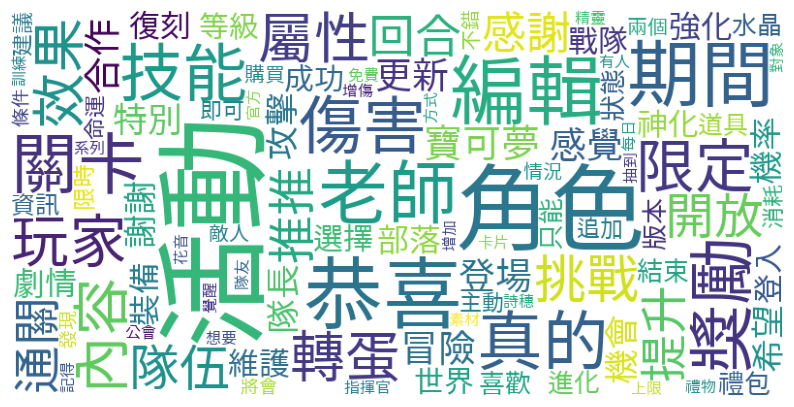

In [18]:
draw_wordcloud(word_df["word"])

miYoHo 板包含了多項米哈遊開發的遊戲，檢視其討論內容字詞:

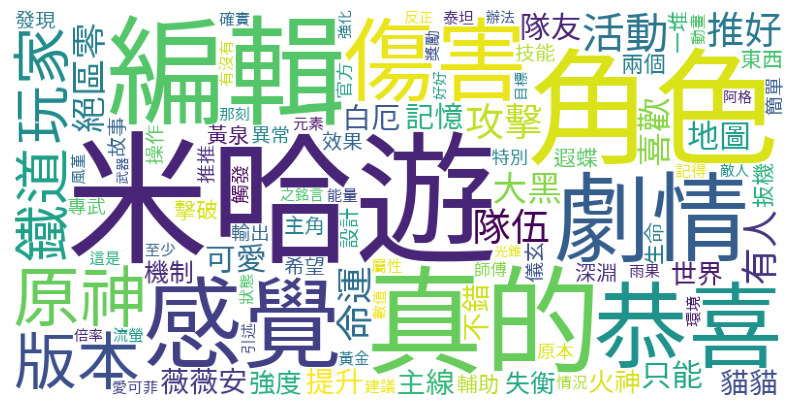

In [19]:
mihoyo_word_df = word_df[word_df["artCategory"] == "miHoYo"]
draw_wordcloud(mihoyo_word_df["word"])

## 情緒分析

本部份以米哈遊之遊戲系列觀察，情緒是否受特定事件影響。

以頻率計算:

In [20]:
liwc_dict = pandas.read_csv(get_dictionary_path("LIWC_CH.csv")) \
    .rename(columns={'name': 'word', "class": 'sentiments'})
liwc_df = pandas.merge(mihoyo_word_df, liwc_dict, how="left")

In [21]:
sentiment_count = DataFrame(
    liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])

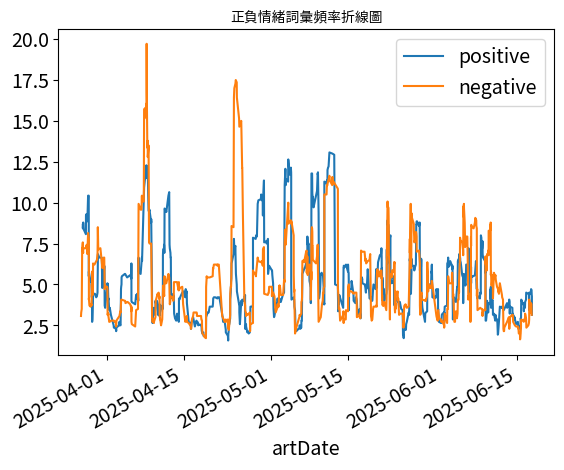

In [22]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)
plt.show()

以比例計算:

Text(0.5, 1.0, '正負情緒比例折線圖')

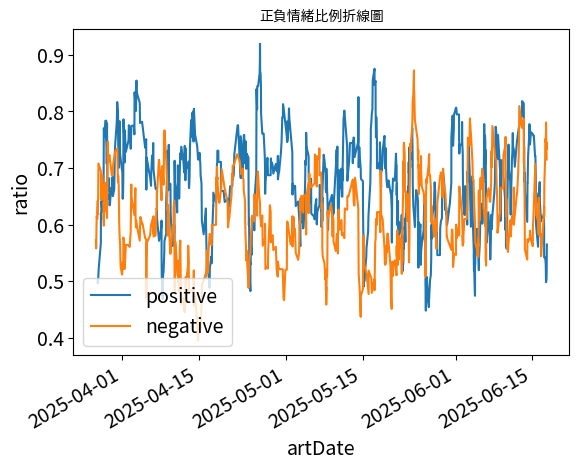

In [23]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

負向分數似乎比預期高，以代表字探究原因:

/tmp/ipython-input-24-3981943103.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/tmp/ipython-input-24-3981943103.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

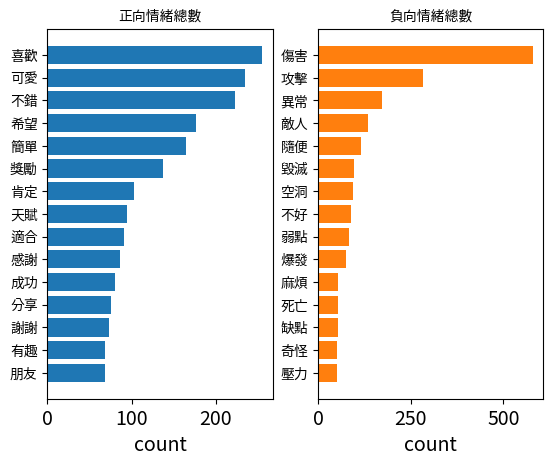

In [24]:
word_count = liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

In [25]:
filtered_df = mihoyo_word_df[mihoyo_word_df['sentence'].str.contains('麻煩', na=False)]
filtered_df.head()

,artUrl,artCategory,artTitle,artContent,artDate,artPoster,sentence,word
1259515,https://www.ptt.cc/bbs/miHoYo/M.1750162095.A.9...,miHoYo,[健檢] [絕區]問送的常駐選擇,\nBOX\n網址\n目前常駐抽還可以300 但還沒抽\n\n有時候會斷月卡黨\n有專武的:...,2025-06-17 12:08:13,qqsheepu (小綿羊),妮可操作比較麻煩一點但女僕影更難用影女僕就有,妮可
1259516,https://www.ptt.cc/bbs/miHoYo/M.1750162095.A.9...,miHoYo,[健檢] [絕區]問送的常駐選擇,\nBOX\n網址\n目前常駐抽還可以300 但還沒抽\n\n有時候會斷月卡黨\n有專武的:...,2025-06-17 12:08:13,qqsheepu (小綿羊),妮可操作比較麻煩一點但女僕影更難用影女僕就有,操作
1259517,https://www.ptt.cc/bbs/miHoYo/M.1750162095.A.9...,miHoYo,[健檢] [絕區]問送的常駐選擇,\nBOX\n網址\n目前常駐抽還可以300 但還沒抽\n\n有時候會斷月卡黨\n有專武的:...,2025-06-17 12:08:13,qqsheepu (小綿羊),妮可操作比較麻煩一點但女僕影更難用影女僕就有,麻煩
1259518,https://www.ptt.cc/bbs/miHoYo/M.1750162095.A.9...,miHoYo,[健檢] [絕區]問送的常駐選擇,\nBOX\n網址\n目前常駐抽還可以300 但還沒抽\n\n有時候會斷月卡黨\n有專武的:...,2025-06-17 12:08:13,qqsheepu (小綿羊),妮可操作比較麻煩一點但女僕影更難用影女僕就有,女僕
1259519,https://www.ptt.cc/bbs/miHoYo/M.1750162095.A.9...,miHoYo,[健檢] [絕區]問送的常駐選擇,\nBOX\n網址\n目前常駐抽還可以300 但還沒抽\n\n有時候會斷月卡黨\n有專武的:...,2025-06-17 12:08:13,qqsheepu (小綿羊),妮可操作比較麻煩一點但女僕影更難用影女僕就有,影更


可見許多用字與遊戲本身內容有關，並非針對體驗而言，唯「麻煩」一詞可能談論遊戲的機制設計。  
同時，可以透過字詞頻率看出討論熱度，反應遊戲活動與更新。